# Spectrum calculations

```{note}
- [ ] Clean up - minimize defining own functions
- [ ] Include CVS-TDDFT
- [ ] Consider RIXS discussion - DKH and 2-step (including polarization) approaches
    - Maybe show improved resolution via HERFD
```

In [2]:
# loading modules etc

# standard Python modules and functions
from scipy.interpolate import interp1d
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import copy

# QC software suites and functionalities
from pyscf import gto, scf, mp, cc
import veloxchem as vlx
import gator
import adcc
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection

# for vlx
silent_ostream = vlx.OutputStream(None)
from mpi4py import MPI
comm = MPI.COMM_WORLD

# au to eV conversion factor
au2ev = 27.211386

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.


(sec:xray_calc_xps)=
## X-ray photoemission spectroscopy

In XPS the photoemission of electrons is measured, yielding information on core-electron binding energies. Here we focus on the calculation of ionization potentials (IP:s), from which the isotropic photoemission spectrum is formed by giving each IP the same intensity and then broadening with a function. Can go beyond that using Dyson orbitals, but it typically doesn't make much of a difference [refs: Dyson, difference]. For more details on the modeling of these processes with ADC and TDDFT, good starting points include [XPS with ADC/TDDFT].

### IP:s from Koopmans' theorem

A simple model for estimating ionization potentials and electron affinities is from Koopmans' theorem, where it is calculated from the MO energies. For water, we obtain a 1s IP estimate of:

In [20]:
water = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""
def vlx_scf(molecule,basis):
    '''
    Crete veloxchem mol and basis option and perform SCF calculation
    '''
    mol_vlx = vlx.Molecule.read_str(water) 
    bas_vlx = vlx.MolecularBasis.read(mol_vlx, basis) 
    scf_vlx = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
    scf_vlx.compute(mol_vlx, bas_vlx)
    return scf_vlx

# SCF calculation
scf_gs = vlx_scf(water,'6-31G')

# Extract orbital energies
orbital_energies = scf_gs.scf_tensors['E']
print('1s IP from the Koopmans theorem:',np.around(au2ev*orbital_energies[0],2))

1s IP from the Koopmans theorem: -559.5


This can be compared to the experimental value, which is 539.9 eV. The overestimation of almost 20 eV is due to lack of [relaxation](relaxation), which results from the reorganization of the valence electrons in response to a reduction in screening of the nuclei. By comparison, in valence spectroscopies the change in shielding is significantly smaller, yielding a far smaller error due to the lack of relaxation for, e.g., calculation of HOMO IP:s or LUMO EA:s.

An approach for including relaxation effects IP calculations is to instead use the $\Delta\textrm{SCF}$ approach, in which the difference in total energy between the neutral and a core-hole system yields estimates of core-electron binding energies.

### The maximum overlap method (MOM)

```{note}
Improve this section.
```

In order to do this, a core-hole state need to be converged, as can be done using a number of methods including...[refs] We will here focus on the use of the maximum overlap method (MOM) [refs], using which a wave function optimization is restricted to contain the maximum overlap to the previous electronic structure. This is done by considering the  eigenvalue equation

\begin{equation}
\textbf{FC}^{\textrm{new}} = 
\textbf{SC}^{\textrm{new}} \epsilon
\end{equation}

We then chose to overlap the most with the span

\begin{equation}
\textbf{O} = 
\left( \textbf{C} \right)^{\dagger} \textbf{SC}^{\textrm{new}}
\end{equation}

A core-hole wave function can then be converged by:

1. Calculating the wave function of the system lacking a core-hole.

2. Use above wave function as a starting guess for a new wave function optimization, removing an electron from desired core orbital.

3. Optimizing this state using the MOM restriction.

This can then converge many unstable states, including core-ionized states and some core-excited states. Some care should observed, though:

- If excited states are considered, check that the final state is reasonable.

- Systems with delocalized core orbitals need to be localized, for example by employing ECP:s [refs].

- If post-HF methods are used, the ground state calculation can attempt to (partially) fill the core-hole, leading to a corrupt wave function which represents some intermediate between a core-hole/valence-hole state [refs].

```{note}
We currently use `pyscf` for the calculations involving explicit core-holes, as VeloxChem lacks MOM (for now).
```

### IP:s from $\Delta\textrm{SCF}$

The IP of water using $\Delta\textrm{SCF}$ is calculated ass:

In [38]:
def pyscf_scf(molecule,basis,unrest=False,dft_xc=None):
    '''
    Create pyscf mol object and perform (U)SCF calculation (HF or DFT)
    '''
    mol       = gto.Mole()
    mol.atom  = molecule
    mol.basis = basis
    mol.build()
    if dft_xc == None:
        if unrest == True: scf_gs = scf.UHF(mol); scf_gs.kernel()
        else:              scf_gs = scf.RHF(mol); scf_gs.kernel()
    else:
        if unrest == True: scf_gs = scf.UKS(mol); scf_gs.xc = dft_xc; scf_gs.kernel()
        else:              scf_gs = scf.RKS(mol); scf_gs.xc = dft_xc; scf_gs.kernel()
    return scf_gs

def pyscf_ch(molecule,basis,gs_scf,core_indx,dft_xc=None):
    '''
    Core-hole calculation performed using MOM
    - corehole in core_indx
    '''
    mol       = gto.Mole()
    mol.atom  = molecule
    mol.basis = basis
    mol.build()
    mo0  = copy.deepcopy(gs_scf.mo_coeff)
    occ0 = copy.deepcopy(gs_scf.mo_occ)
    occ0[0][core_indx] = 0.0
    if dft_xc == None:
        scf_ion = scf.UHF(mol)
        scf.addons.mom_occ(scf_ion, mo0, occ0)
        scf_ion.kernel()
    else:
        scf_ion = scf.UKS(mol)
        scf.addons.mom_occ(scf_ion, mo0, occ0)
        scf_ion.xc = dft_xc
        scf_ion.kernel()
    return scf_ion

# Build mol-object and perform ground state (unresticted) SCF with pyscf
scf_gs  = pyscf_scf(water,'6-31G',True)

# Perform wave function calculation with the MOM restriction
scf_ion = pyscf_ch(water,'6-31G',scf_gs,0)

# Resulting IP from energy difference
print('Ionization potential:',np.around(au2ev*(scf_ion.energy_tot() - scf_gs.energy_tot()),2),'eV')

converged SCF energy = -75.9838703827193  <S^2> = 6.3389294e-12  2S+1 = 1
converged SCF energy = -56.0754789470864  <S^2> = 0.76257805  2S+1 = 2.0125387
Ionization potential: 541.73 eV


This estimate is within 2 eV from experiment, and we can include electron correlation using MP2:

In [36]:
# Run MP2 on neutral and core-hole wave functions
mp_res = mp.MP2(scf_gs).run()
mp_ion = mp.MP2(scf_ion).run()

# IP from energy difference
print('Ionization potential:',np.around(au2ev*(mp_ion.e_tot - mp_res.e_tot),2),'eV')

E(UMP2) = -76.1130483955489  E_corr = -0.129178012829703
E(UMP2) = -56.1523709631034  E_corr = -0.0768920160169645
Ionization potential: 543.16 eV


And we can also use KS-DFT:

In [39]:
# SCF calculation with unrestricted KS-DFT
scf_gs  = pyscf_scf(water,'6-31G',True,'b3lyp')

scf_ion = pyscf_ch(water,'6-31G',scf_gs,0,'b3lyp')

# IP from energy difference
print('Ionization potential:',np.around(au2ev*(scf_ion.energy_tot() - scf_gs.energy_tot()),2),'eV')

converged SCF energy = -76.3480474320838  <S^2> = 2.5509372e-11  2S+1 = 1
converged SCF energy = -56.4125421194361  <S^2> = 0.75441021  2S+1 = 2.0044054
Ionization potential: 542.47 eV


MP2 and DFT currently brings us **away** from experiment, but we note that the basis set is small and ill suited for core properties. Using a cc-pCVTZ basis we obtain:
- HF: 538.93 eV
- MP2: 540.26 eV
- B3LYP: 539.19 eV

*i.e.* closer to experiment for the correlated methods (note that scalar-relativistic effects will shift these results upwards by $\sim$0.37 eV).

### Spectra from $\Delta\textrm{SCF}$

The X-ray photoemission spectrum can be formed by calculating all relavant core-electron binding energies (IP:s), give each unique ionization equal intensity, and broaden over the result with a lorentzian or gaussian convolution formula. The choice of broadening depends on the dominant broadening effect (lifetime of excited/ionized state, experimental resolution, *etc*), but we will here focus on pure lorentzian broadening.

We here consider ethyl trifluoroacetate( (CF$_3$-CO-O-CH$_2$-CH$_3$), also known as the ['ESCA' molecule](https://doi.org/10.1016/j.elspec.2012.05.009), which possess very illustrative shifts in XPS features (IP:s) of the carbon $K$-edge due to interactions with the very electronegative oxygen and fluorine atoms. We calculate the four carbon 1s IP:s with $\Delta\textrm{SCF}$:

In [40]:
esca   = '''
C         1.1183780041   -0.3449927563    0.0140172822
C         0.2599020293    0.9430366372   -0.0248385056
F         2.4019839124   -0.0408200726   -0.0368443870
F         0.8399255955   -1.1560630574   -1.0169777359
F         0.8945563482   -1.0267696528    1.1485539196
O         0.7954196415    2.0187110930    0.0011424145
O        -1.0675509573    0.8144007049   -0.0614767265
C        -1.7486063992   -0.4602333713   -0.1739210991
C        -3.1986940727   -0.1850294900    0.1302033614
H        -1.3268717284   -1.1720377773    0.5289059043
H        -1.6185520565   -0.8344576449   -1.1859838788
H        -3.3116641442    0.1959612359    1.1419001202
H        -3.7716619472   -1.1057672384    0.0380096706
H        -3.6012985602    0.5468300237   -0.5651778685            
'''

# Create mol object and perform neutral SCF calculation
scf_gs  = pyscf_scf(esca,'STO-3G',True)

# Perform core-hole calculation for each carbon atom (MOs 5-8) and append SCF IPs to a list
esca_ips = []
for i_mo in [5,6,7,8]:
    ion_tmp = pyscf_ch(esca,'STO-3G',scf_gs,i_mo)
    esca_ips.append(au2ev*(ion_tmp.energy_tot() - scf_gs.energy_tot()))

converged SCF energy = -594.32069026359  <S^2> = 1.6621925e-08  2S+1 = 1
converged SCF energy = -583.365537674046  <S^2> = 0.76705671  2S+1 = 2.0169846
SCF not converged.
SCF energy = -583.447978420814 after 50 cycles  <S^2> = 0.76806071  2S+1 = 2.0179799
converged SCF energy = -583.561134582533  <S^2> = 0.76454928  2S+1 = 2.0144967
converged SCF energy = -583.615548638302  <S^2> = 0.75826809  2S+1 = 2.0082511


```{note}
There are some convergence issues for the above calculation, largely relating to the minimal basis set used. These issues disappear for more flexible basis set.
```

The spectrum is formed by giving each IP equal weight and broadening with a lorentzian and a gaussian, for which FWHM $= \gamma $ and FWHM $ 2\sqrt{2\ln{2}} \sigma$, respectively.

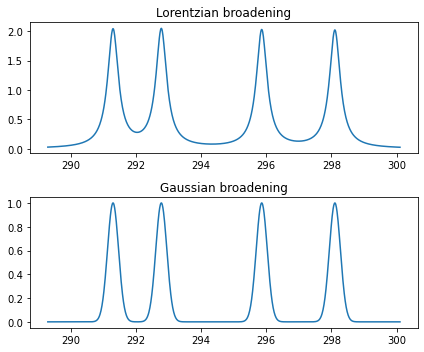

In [41]:

# broadening functions, called with
#         (energies, intensities, start energy, end energy, energy step, broadening)
def lorentzian(x, y, xmin, xmax, xstep, gamma):
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)): yi[i] = yi[i] + y[k] * (gamma/2.) / ( (xi[i]-x[k])**2 + (gamma/2.)**2 )
    return xi,yi

def gaussian(x, y, xmin, xmax, xstep, sigma):
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(y)):
            yi[i] = yi[i] + y[k]*np.e**(-((xi[i]-x[k])**2)/(2*sigma**2))
    return xi,yi

plt.figure(figsize=(6,5))
# Broadening with a lorentzian, with FWHM = 0.4 eV
plt.subplot(211); plt.title('Lorentzian broadening')
x,y = esca_ips,np.ones((len(esca_ips)))
xi,yi = lorentzian(x,y,min(x)-2,max(x)+2,0.01,0.4); plt.plot(xi,yi*0.4)
# Broadening with a gaussian, with FWHM = 0.4 eV
plt.subplot(212); plt.title('Gaussian broadening')
xi,yi = gaussian(x,y,min(x)-2,max(x)+2,0.01,0.4/(2*np.sqrt(2*np.log(2)))); plt.plot(xi,yi)
plt.tight_layout(); plt.show()

For the comparison to [experiment](https://doi.org/10.1016/j.elspec.2012.05.009) a cc-pVTZ basis set is selected, augmented with additional core-polarizing functions for the carbon atoms (i.e. cc-pCVTZ):


```{figure} ../img/xray/esca_xps.svg
---
name: esca_xps
---
Carbon 1s XPS of ESCA, comparing $\Delta\textrm{SCF}$ results to experiment. Theoretical spectrum shifted by 0.11 eV (to account for relativistic effects) and broadened by 0.3 eV.
```

The features originate in, from low to high energy: -CH$_3$, -CH$_2$-, -CO-, and CF$_3$. We note a good agreement for the first two features, but the comparison deteriorates for higher energies. This is largely an effect of the more significant change in electronic structure imposed by the very electronegative fluorine and oxygen atoms, which the current level of theory is not capable of describing as well as the other features.

### Other approaches

Brief discussion - IP-ADC, IP-CCSD, ...


(sec:xray_calc_xas)=
## X-ray absorption spectroscopy

In XAS the energy-dependent photoabsorption of the sample is measured, probing excitation of core electrons to bound or continuum states. These two different final states then provide information on unoccupied states and local chemical environment, espectively, with a prototypical spectrum of a conjugated system: 


```{figure} ../img/xray/xafs.svg
---
name: xafs
---
Prototypical X-ray absorption spectrum of a conjugated system.
```

Above the spectrum we see the distinction of the various spectrum regions, consisting of:

- **NEXAFS (near-edge X-ray absorption fine structure:** the region in which transitions to bound states is probed (this region is also known as XANES, X-ray absorption near-edge structure).

- **EXAFS (extended X-ray absorption fine structure):** which consists of transitions to continuum states, which is modulated by constructive or destructive interference between the emitted electron and the environment. This thus provide information on local chemical bonds.

- **XAFS (X-ray absorption fine structure):** spanning both regions.

For the remainder of this tutorial we will focus on NEXAFS, with more details for modeling this process found in [wenzel, besley, fransson]. Discussions on modeling EXAFS can be found, e.g., in [exafs].

Included in {numref}`xafs` is also the position of the IP, above which the oscillatory pattern due to interference with the environment is initiated, and assignment of typical features ($\pi^*$, Rydberg, and $\sigma^*$). Transitions to $\pi^*$ states are typically low in energy and very intense, and thus easy to identify. Rydberg states are typically weak and converge to the ionization potential. Finally, transitions to $\sigma^*$ states can be found above the ionization potential.

(sec:xray_calc_cvs)=
### Decoupling transitions from the valence continuum

A complication that arise when considering core excitations is the embedding of the core-excited states into the continuum of valence-ionized states. A number of approaches have been developed to remove this issue, including:

- The core-valence separation (CVS) approximation [schirmer, wenzel, coriani]

- Restricted energy window, which share some common ideas with CVS [rew-tddft]

- Using the complex polarization propagator (CPP), where the response at arbitrary frequencies is directly probed [norman]

- Real-time propagation of the electronic structure [rt-methods]

- Methods which construct explicit excited states [refs]

The focus in this tutorial is the use of the CVS approximation and the CPP approach, with which interior eigenstates/response at arbitrary frequencies can be directly address:


```{figure} ../img/xray/cvs_adc.svg
---
name: cvs_adc
---
Global spectrum of water, using the 6-311G basis set. Results obtained with ADC(1), CVS-ADC(1), ADC(2), CVS-ADC(2), and CPP-DFT. CPP-DFT results obtained using the B3LYP exchange-correlation functional and a large $\gamma$ of 1 eV.
```

Here we see the global spectrum of water, using a rather limited basis set. Even so, ADC(1) requires more than 50 states to resolved the core-excitation region (situated at about 535 eV for water), and for ADC(2) 50 states brings us only to about 50 eV. With the CVS approximation we directly target the core-excitation region, but it should be noted that this also introduces a small error. However, this error has been shown to be relatively small (provided a reasonable basis set) and stable for [ADC](https://doi.org/10.1063/5.0013538), and for TDHF and TDDFT it is all but negligible. Using CPP-DFT, the error is avoided all together.


### Spectra from CVS-ADC eigenstates

With CVS-ADC, the core-excitation spectra are calculate by specifying the index of the probed core orbitals(s):

In [8]:
# Construct molecule reference object and perform SCF calculation 
struct  = gator.get_molecule(water)
basis   = gator.get_molecular_basis(struct,'6-31G')
scf_res = gator.run_scf(struct,basis)

# Calculate the 6 lowest eigenstates with CVS restriction to MO #1 (oxygen 1s)
adc_res = gator.run_adc(struct,basis,scf_res,method='cvs-adc2x',singlets=6,core_orbitals=1)

SCF converged in 5 iterations.
Total Energy: -75.9838703758 au
                                                                                                                          
                                        Algebraic Diagrammatic Construction (ADC)                                         
                                                                                                                          
                               ADC method                   : cvs-adc2x                                                   
                               Number of Singlet States     : 6                                                           
                               CVS-ADC, Core Orbital Space  : 1                                                           
                               Convergence threshold        : 1.0e-06                                                     
                                                                            

/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting cvs-adc2x singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8        1.4139  139ms  [20.27035892 20.30081816 20.86977772 20.91121522 21.10647259 21.17210946]
  2    16       0.05362  416ms  [19.72495578 19.80691954 20.50880994 20.51569977 20.52445847 20.72564031]
  3    24      0.014469  335ms  [19.71673636 19.7970775  20.49577427 20.50503424 20.5080414  20.63850295]
  4    32      0.001267  338ms  [19.71639053 19.79671148 20.49373711 20.5048401  20.50629308 20.62964455]
  5    40    0.00011958  422ms  [19.71637564 19.7966997  20.49353395 20.50482654 20.50617672 20.62883047]
=== Restart ===
  6    16    2.2907e-05  336ms  [19.71637513 19.79669899 20.4935131  20.5048246  20.50616999 20.6287565 ]
  7    24    8.2765e-06  281ms  [19.7163751  19.7966989  20.49350792 20.50482377 20.50616868 20.62873489]
  8    32    3.7389e-06  409ms  [19.7163751  19.7966989  20.49350748 20.50482367 20.5061685  20.62872983]
  9    40     5.189e-07  403ms  [19.7163751  

The resuls can be printed as a table, or convoluted and plotted using built-in functionalities or a custom broadening:

+--------------------------------------------------------------+
| cvs-adc2x                               singlet ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      19.71638      536.5099   0.0175    0.8001    0.1999  |
|  1       19.7967      538.6956   0.0368    0.8087    0.1913  |
|  2      20.49351      557.6567   0.0098    0.7858    0.2142  |
|  3      20.50482      557.9647   0.1007    0.8441    0.1559  |
|  4      20.50617      558.0013   0.0881     0.835     0.165  |
|  5      20.62873      561.3363   0.0104    0.7926    0.2074  |
+--------------------------------------------------------------+



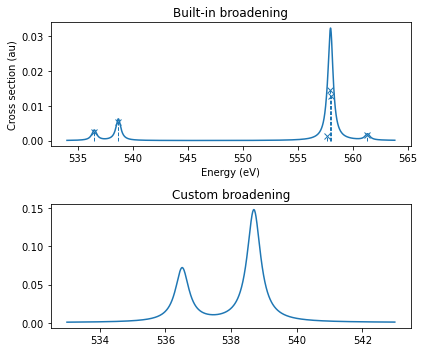

In [9]:
# Print information on eigenstates
print(adc_res.describe())

plt.figure(figsize=(6,5))
# Convolute using functionalities available in gator and adcc
plt.subplot(211); plt.title('Built-in broadening')
adc_res.plot_spectrum()
# Convoluted using information on excitation energies and oscillator strengths
plt.subplot(212); plt.title('Custom broadening')
x,y = au2ev*adc_res.excitation_energy, adc_res.oscillator_strength
xi,yi = lorentzian(x,y,533,543,0.01,0.5); plt.plot(xi,yi)
plt.tight_layout(); plt.show()

The built-in functionality uses a small default broadening (which can be changed) and plots the full region which is resolved, while we might want to focus on lower-energy and larger broadenings (as done in the lower panel). We note that high-energy features can often be a result of a discretized continuum region, as seen by the unphysically intense feature at 558 eV. A larger basis set will flatten out this region, but care should be taken for any analysis of it [refs].

Increasing the basis set to aug-cc-pCVTZ/cc-pVTZ (for oxygen and hydrogen, respectively), we obtain results in good agreement to experiment:


```{figure} ../img/xray/adc_water_xas.svg
---
name: adc_water_xas
---
CVS-ADC(2)-x calculation of the oxygen X-ray absorption spectrum of gaseous water, as compared to experiment. Theoretical spectra has been shifted by 0.37 eV (to account for relativistic effects) and broadened by 0.4 eV.
```


### Spectra from TDDFT eigenstates


```{note} 
To be added.
```


### Spectra from CPP-DFT

With the complex polarization propagator (CPP), also called the damped linear response function, the absorption and dispersion spectrum can be evaluated at arbitrary energies. With this, the X-ray absorption spectrum using KS-DFT can then be directly calculated.

For this, we just need to decide on which energy/frequency region to use, which can be estimated by, e.g.

- Screen more extended energy regions with low step length. This could potentially be done using a smaller basis set.

- With a method lacking relaxation: start the region a few eV below the IP from Koopmans' theorem. This will not work for methods capable of including relaxation, where IP:s from $\Delta$SCF could instead be considered as a first rough estimate (noting that it will work better or worse for different levels of, e.g., ADC theory).

Choosing an energy region of 514-525 eV, using a step length of 0.1 eV and a damping factor of 0.3 eV, we calculate the CPP-DFT (B3LYP) water spectrum as:

In [10]:
# Prepare molecule object
molecule = vlx.Molecule.read_str(water, units='angstrom')
basis    = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF  settings and calculation
scf_drv         = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_settings    = {'conv_thresh': 1.0e-6}
method_settings = {'xcfun': 'b3lyp', 'grid_level': 4}
scf_drv.update_settings(scf_settings,method_settings)
scf_drv.compute(molecule, basis)

# Calculate the response at desired frequencies
freqs = np.arange(515.0,525.0,0.1)/au2ev; freqs_str = [str(x) for x in freqs]
cpp_prop = LinearAbsorptionCrossSection({'frequencies': ','.join(freqs_str), 'damping': 0.3/au2ev},
                                        method_settings)
cpp_prop.init_driver(comm, ostream=silent_ostream)
cpp_prop.compute(molecule, basis, scf_drv.scf_tensors)

# Extract the imaginary part of the complex response function and convert to absorption cross section
sigma = []
for w in freqs:
    axx = -cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag
    ayy = -cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag
    azz = -cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag
    alpha_bar = (axx + ayy + azz) / 3.0; sigma.append(4.0 * np.pi * w * alpha_bar / 137.035999)

Resulting spectra can be plotted as raw or splined, for smoother figures:

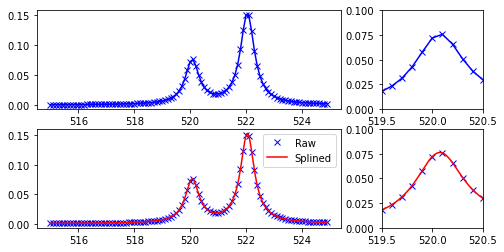

In [11]:
# Make figure with panels of 3:1 width
plt.figure(figsize=(8,4))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1]) 

# Raw results for full region
plt.subplot(gs[0])
plt.plot(au2ev*freqs,sigma,'bx-')

# Raw results for zoomed in
plt.subplot(gs[1])
plt.plot(au2ev*freqs,sigma,'bx-')
plt.xlim((519.5,520.5)); plt.ylim((0,0.10))

# Raw and splined spectra
plt.subplot(gs[2])
plt.plot(au2ev*freqs,sigma,'bx')
x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
y = interp1d(au2ev*freqs, sigma, kind='cubic')
plt.plot(x,y(x),'r')
plt.legend(('Raw','Splined'))

# Zoomed in
plt.subplot(gs[3])
plt.plot(au2ev*freqs,sigma,'bx')
plt.plot(x,y(x),'r')
plt.xlim((519.5,520.5)); plt.ylim((0,0.10))
plt.show()

Increasing the basis set size and comparing to [experiment] we get:


```{figure} ../img/xray/dft_water_xas.svg
---
name: dft_water_xas
---
CPP-DFT (B3LYP) X-ray absorption spectrum of water, as compared to experiment. Theoretical spectra shifted by 14.5 eV and broadened by 0.4 eV. Currently aug-cc-pVDZ..
```

```{note} 
Change above to aug-cc-pCVTZ/cc-pVTZ.
```

As can be seen, the absolute excitation energies are significantly of, with a shift of 14.5 eV required to yield an approximate alignment to experiment. Part of this shift is due to lack of relativistic effects (~0.37 eV), and a small discrepancy can be expected due to the use of a limited basis set, but the main part of the error is due to two different effects:

1. Lack of [relaxation](#relaxation), which yield a final state too high in energy and thus shift theoretical spectra upwards in energy.

2. The [self-interaction error](#self-interaction-error-in-dft), which yield an erroneous self-repulsion of the dense core orbitals, and results in too low core-excitation energies.

For B3LYP the total effect of these two errors leads to too low transition energies, meaning that the SIE dominates. By changing the amount of HF exchange this balance will shift and the error eventually becomes positive.

Nevertheless, the obtained CPP-DFT spectrum is in reasonable agreement with experiment once it has been shifted.


### Other approaches

Brief discussion - state-specific, CC, MR, ...

(sec:xray_calc_xes)=
## X-ray emission spectroscopy

Following the creatying of a core-hole, the system will rapidly ($\sim$fs) decay to a valence-hole or valence-excited satte, depending on whether the system is core-ionized or core-excited. These two different intermediate states  are probed when the X-ray pulse is in non-resonant (ionized) or resonant (excited regime), yieldig non-resonant/resonant X-ray emission spectroscopy. This section will focus on the former, with the latter following in the next section.

In the decay process the system gain large amounts of energy which need to be discarded, which can occur by emission of high-energy photon (fluorescence) or higher-lying electron (Auger), with relative probability depending on edge and element. For the *K*-edge the relative probabilities follow:

```{figure} ../img/xray/auger_vs_fluorescent.png
---
name: auger_vs_fluorescent
---
Fluorescence and Auger electron yields as a function of atomic number for *K*-edge core-holes. [Published](https://commons.wikimedia.org/wiki/File:Auger_xray_wiki_in_png_format.png) under CC BY-SA 4.0.
```

As can be seen, Auger decay dominates for light elements, which has impact on both our ability of obtaining well-resolved spectra for these elements, as well as the impact of X-ray damage on biological matter.

In non-resonant XES we then probe the radiative decay of core-ionized states, through which we can probe the (element-specific) nature of the local chemical environment. For light elements the valence space is probed directly, but for heavier elements we obtain a number of different decay channels from the valence region and the outer core region. These lines vary considerably in energy, intensity, and information content [refs]:

1. The $2p \rightarrow 1s$ ($K\alpha_1$ and $K\alpha_2$) is the most intense (due to the large overlap) and of lowest energy, and is relatively insensitive to the valence region.

2. The $3p \rightarrow 1s$ ($K\beta ' $ and $K\beta_{1,3}$) is about an order of magnitude weaker and of higher energy, but more sensitive to the environment.

3. Transitions from the ligand MO:s ($K\beta '' $ and $K\beta_{2,5}$), or valence-to-core (VtC), is the weakest, high-energy features which is most sensitive to the local environment.

The discussion in this tutorial will focus on spectra of lighter elements, as can be modelled with DFT and ADC theory. A good starting point for such calculations include [XPS with ADC/TDDFT].


### Spectra from ADC

One approach for considering X-ray emission spectra is to converge the core-hole state (as above for $\Delta\textrm{SCF}$) and use this core-ionized system as the reference state. The core-decay transition then are the first negative eigenstates of the systemn, such that a standard Davidson calculation can be run on top.

Considering water with ADC(2), the oxygen X-ray emission spectrum is calculated as:

In [12]:
# Construct molecule object
mol       = gto.Mole()
mol.atom  = water
mol.basis = '6-31G'
mol.build()

# Perform neutral SCF calculation
scf_res = scf.UHF(mol)
scf_res.kernel()

# Use above SCF as starting guess, removing core electron and converging with MOM constraint
mo0        = copy.deepcopy(scf_res.mo_coeff)
occ0       = copy.deepcopy(scf_res.mo_occ)
occ0[0][0] = 0.0
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# Perform ADC calculation
adc_xes = adcc.adc2(scf_ion, n_states=4)

converged SCF energy = -75.9838703827193  <S^2> = 6.337153e-12  2S+1 = 1
converged SCF energy = -56.0754789470864  <S^2> = 0.76257805  2S+1 = 2.0125387


/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8       0.77768   1.2s  [-19.29082067 -19.19940205 -18.96181907 -18.3637012 ]
  2    16     0.0010764  162ms  [-19.44427093 -19.36689642 -19.16826546 -18.57947501]
  3    24    4.4301e-07  274ms  [-19.44429764 -19.3669284  -19.16831914 -18.57954987]
=== Converged ===
    Number of matrix applies:    24
    Total solver time:             1s 642ms


```{note}
There will be some convergence issues if including transitions from very different types, *e.g.* resolving transitions into the core and out to the unoccupied valence region simultaneously. As such, the number of resolved states should remain somewhat limited.
```

The resuls can be printed as a table, or convoluted and plotted using built-in functionalities or a custom broadening. Note that the eigenvalues are negative, and a sing change is appropriate when constructing the spectra.

+--------------------------------------------------------------+
| adc2                                        any ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      -19.4443     -529.1063   0.0568    0.9548    0.0452  |
|  1     -19.36693      -527.001   0.0458    0.9503   0.04966  |
|  2     -19.16832     -521.5965   0.0419    0.9376   0.06245  |
|  3     -18.57955     -505.5753   0.0031    0.9335   0.06655  |
+--------------------------------------------------------------+



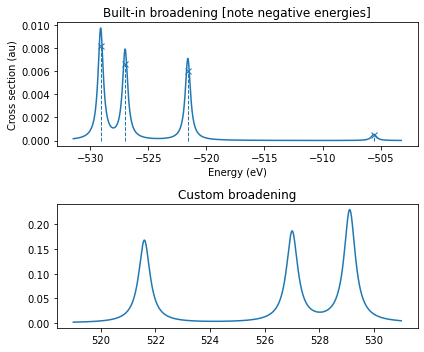

In [13]:
# Print information on eigenstates
print(adc_xes.describe())

plt.figure(figsize=(6,5))
# Convolute using functionalities available in gator and adcc
plt.subplot(211); plt.title('Built-in broadening [note negative energies]')
adc_xes.plot_spectrum()
# Convoluted using information on excitation energies and oscillator strengths
plt.subplot(212); plt.title('Custom broadening')
x,y = -au2ev*adc_xes.excitation_energy, adc_xes.oscillator_strength
xi,yi = lorentzian(x,y,519,531,0.01,0.5); plt.plot(xi,yi)
plt.tight_layout(); plt.show()

Using cc-pCVTZ/cc-pVTZ and comparing to experiment:

```{figure} ../img/xray/overlap_water_xes.svg
---
name: overlap_water_xes
---
ADC(2) water X-ray emission spectrum, as compared to experiment. Theoretical spectra shifted by 0.37 eV (to account for relativistic effects) and broadened by 0.3 eV.
```

While the broadening between the different lines is noticably different, it is clear that the energy spacing and integrated intensities of the features are in good agreement with experiment. Note that the theoretical spectrum is obtained at the ADC(2) level of theory, which has been [shown](https://doi.org/10.1021/acs.jctc.8b01046) to be in better agreement than ADC(2)-x and ADC(3/2) for XES.


### Spectra from TDDFT

```{note}
To be added.
```

### Spectra from ground state MO:s

While we have previously seen that Koopmans' theorem is in significant disagreement with experimental ionization potentials (due to lack of relaxation), it has been noted that the **relative** position of the (valence) MO energies can still be quite reasonable. As such, a computationally very simple approach for modeling X-ray emission spectra has been utilized [refs], in which transition energies are estimated from

\begin{equation}
\Delta E = \epsilon_v - \epsilon_c
\end{equation}

*i.e.* the difference in ground state MO energies. The intensities are taken to be proportional to the dipole moment:

\begin{equation}
f \propto \left| \langle \phi_i \left| \hat{\mu} \right| \phi_c \rangle \right| ^2
\end{equation}

This method is very attractive in its simplicity, requiring only a single ground state calculation and the construction of some dipole moments for a full spectrum calculation. However, the absolute energies will be significantly off, and any differences in relaxation between the different channels will not be included.

Nevertheless, this approach has been noted to yield good (relative) agreement to experimental measurements, and it is very capable of considering even massive molecular systems [refs]. The calculation of it then requires two steps:

- The calculation of ground state wave function and constructing transition energies from MO energy differences:

In [14]:
# SCF calculation
scf_drv          = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_settings     = {'conv_thresh': 1.0e-6}
method_settings  = {'xcfun': 'b3lyp', 'grid_level': 4}
scf_drv.update_settings(scf_settings,method_settings)
scf_drv.compute(molecule, basis)

# Extract orbital energies and number of occupied MOs
orbital_energies = scf_drv.scf_tensors['E']
nocc = molecule.number_of_alpha_electrons()
print('Occupied MO energies:',au2ev*orbital_energies[:nocc])

# Define probed core MO(s) and calculate energy differences
n_core = 0
overlap_energy = []
for n_mo in np.arange(nocc):
    if n_mo != n_core:
        overlap_energy.append(au2ev*(orbital_energies[n_mo]-orbital_energies[n_core]))

Occupied MO energies: [-520.65709504  -27.68789281  -14.39952883   -9.70377533   -7.94952959]


- The calculation of dipole moments between the occupied states:

In [15]:
# Load required functionalities
dipole_drv      = vlx.ElectricDipoleIntegralsDriver(comm)
dipole_matrices = dipole_drv.compute(molecule, basis)
C = scf_drv.scf_tensors['C'] # MO coefficients

# Calculated dipole moments and convert to MO basis
x_ao = dipole_matrices.x_to_numpy(); x_mo = np.matmul(C.T, np.matmul(x_ao, C))
y_ao = dipole_matrices.y_to_numpy(); y_mo = np.matmul(C.T, np.matmul(y_ao, C))
z_ao = dipole_matrices.z_to_numpy(); z_mo = np.matmul(C.T, np.matmul(z_ao, C))

# Calculate transition dipole moments and square modulus
xx,yy,zz,osc_str = [],[],[],[]
for n_mo in np.arange(nocc):
    if n_mo != n_core:
        x_tmp,y_tmp,z_tmp = x_mo[n_core,n_mo],y_mo[n_core,n_mo],z_mo[n_core,n_mo]
        xx.append(x_tmp); yy.append(y_tmp); zz.append(z_tmp)
        osc_str.append(x_tmp**2+y_tmp**2+z_tmp**2)

From this we get the stick spectrum, which is printed with its decomposition. Further, it can be convoluted with a lorentzian, here focusing on the high-energy features.

Energy   Osc. str.   x-component   y-component   z-component
492.969   0.00022      0.00000      -0.00000      -0.01478
506.258   0.00238     -0.04878       0.00000       0.00000
510.953   0.00255     -0.00000      -0.00000       0.05050
512.708   0.00342     -0.00000       0.05848       0.00000


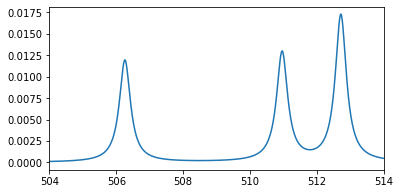

In [16]:
print('Energy   Osc. str.   x-component   y-component   z-component')
for i in np.arange(len(overlap_energy)):
    e,os,x,y,z = overlap_energy[i],osc_str[i],xx[i],yy[i],zz[i]
    print('{:.3f}  {:8.5f}     {:8.5f}      {:8.5f}      {:8.5f}'.format(e,os,x,y,z))

plt.figure(figsize=(6,3))
x,y = overlap_energy,osc_str
xi,yi = lorentzian(x,y,min(x)-5,max(x)+5,0.01,0.4)
plt.plot(xi,yi)
plt.xlim((504,514))
plt.show()

Using cc-pCVTZ/cc-pVTZ and comparing to experiment


```{figure} ../img/xray//overlap_water_xes.svg
---
name: /overlap_water_xes
---
DFT (B3LYP) overlap X-ray emission spectrum of water, as compared to experiment. Theoretical spectra shifted to approximately align the high-energy feature, and broadened by 0.3 eV.
```

The resulting spectrum is quite off in energy, but the relative agreement to experiment is quite impressive.


### Other approaches

Brief discussion - CC, ...

(sec:xray_calc_rixs)=
## Resonant inelastic X-ray scattering

```{note}
- To be added.

- One-step versus two-step.
```

Here focus on the electronic part of he RIXS plane.


### Two-step approach with ADC

In [115]:
# Construct molecule object
mol       = gto.Mole()
mol.atom  = water
mol.basis = '6-31G'
mol.build()
# Perform neutral SCF calculation
scf_res = scf.UHF(mol)
scf_res.kernel()
# XAS
adc_xas = adcc.cvs_adc2(scf_res, n_states=5,core_orbitals=1)

adc_rixs = []
for n in [5,6]:
    mo0        = copy.deepcopy(scf_res.mo_coeff)
    occ0       = copy.deepcopy(scf_res.mo_occ)
    occ0[0][0] = 0.0; occ0[0][n] = 1.0
    scf_ion = scf.UHF(mol); scf.addons.mom_occ(scf_ion, mo0, occ0)
    scf_ion.kernel()
    adc_rixs.append(adcc.adc2(scf_ion, n_states=4))

converged SCF energy = -75.9838703827191  <S^2> = 6.3398176e-12  2S+1 = 1
Starting cvs-adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8        1.6222  841ms  [20.26123431 20.31992537 20.32302691 20.3464984  20.77599022]
  2    16      0.059729  165ms  [19.77470975 19.80230856 19.84312303 19.87818817 20.5373859 ]
  3    24     0.0025223  286ms  [19.75718509 19.78334186 19.84056229 19.86585919 20.53732181]
  4    32    0.00064877  237ms  [19.75656768 19.78236576 19.84024749 19.86584883 20.53732181]
  5    38    2.0368e-05  272ms  [19.756435   19.78211629 19.84024749 19.86584882 20.53732181]
=== Converged ===
    Number of matrix applies:    38
    Total solver time:             1s 823ms


In [120]:
print(adc_xas.describe())
print(adc_rixs[0].describe())
print(adc_rixs[1].describe())

XAS
+--------------------------------------------------------------+
| cvs-adc2                                    any ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      19.75644         537.6   0.0000    0.8488    0.1512  |
|  1      19.78212      538.2988   0.0166    0.8393    0.1607  |
|  2      19.84025      539.8806   0.0000    0.8617    0.1383  |
|  3      19.86585      540.5773   0.0356    0.8518    0.1482  |
|  4      20.53732       558.849   0.0000    0.9255   0.07451  |
+--------------------------------------------------------------+


LUMO
+--------------------------------------------------------------+
| adc2                                        any ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au

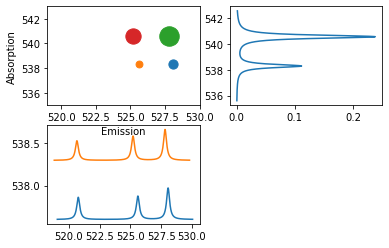

In [123]:
plt.figure()
plt.subplot(222)
x,y = au2ev*adc_xas.excitation_energy, adc_xas.oscillator_strength
xi,yi = lorentzian(x,y,min(x)-2,min(x)+5,0.01,0.3)
plt.plot(yi,xi)
plt.subplot(223)
x,y = -au2ev*adc_rixs[0].excitation_energy, adc_rixs[0].oscillator_strength
xi,yi = lorentzian(x,y,x[1]-9,x[1]+2,0.01,0.3)
plt.plot(xi,yi+au2ev*adc_xas.excitation_energy[0])
x,y = -au2ev*adc_rixs[1].excitation_energy, adc_rixs[1].oscillator_strength
xi,yi = lorentzian(x,y,x[1]-9,x[1]+2,0.01,0.3)
plt.plot(xi,yi+au2ev*adc_xas.excitation_energy[1])

plt.subplot(221)
# LUMO
indx = 1
f1xas = au2ev*adc_xas.excitation_energy[indx]
f1xes = -au2ev*adc_rixs[0].excitation_energy[1]
f1int = adc_xas.oscillator_strength[indx]*adc_rixs[0].oscillator_strength[1]
f2xas = f1xas
f2xes = -au2ev*adc_rixs[0].excitation_energy[2]
f2int = adc_xas.oscillator_strength[indx]*adc_rixs[0].oscillator_strength[2]
plt.plot(f1xes,f1xas,'o',markersize=10000*f1int)
plt.plot(f2xes,f2xas,'o',markersize=10000*f2int)
# LUMO+1
indx = 3
f1xas = au2ev*adc_xas.excitation_energy[indx]
f1xes = -au2ev*adc_rixs[1].excitation_energy[1]
f1int = adc_xas.oscillator_strength[indx]*adc_rixs[1].oscillator_strength[1]
f2xas = f1xas
f2xes = -au2ev*adc_rixs[1].excitation_energy[2]
f2int = adc_xas.oscillator_strength[indx]*adc_rixs[1].oscillator_strength[2]
plt.plot(f1xes,f1xas,'o',markersize=10000*f1int)
plt.plot(f2xes,f2xas,'o',markersize=10000*f2int)
plt.ylim((535,543)); plt.xlim((519,530))
plt.xlabel('Emission'); plt.ylabel('Absorption')
plt.show()

### Two-step approach with TDDFT

```{note}
To be added.
```


### Dirac-Kramer-Heisenberg with ADC

```{note}
To be added.
```


### Other approaches

Overlap approach...?

